# Protein Sequence Classification: Exploratory Data Analysis

Dataset is from Kaggle. Kindly download data from the [link](https://www.kaggle.com/datasets/shahir/protein-data-set)

In [ ]:
# Check GPU for LSTM and BERT models to run
import torch
use_cuda=torch.cuda.is_available()
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu")

GPU acceleration enabled


### Check mps or gpu on mac m1

In [ ]:
import torch
device = "mps" if getattr(torch, 'has_mps', False)\
else 'gpu' if torch.cuda.is_available() else 'cpu'
print(device)

mps


In [ ]:
gpu = len(tf.config.list_physical_devices("GPU"))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Physical devices cannot be modified after being initialized


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus, 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1Metal device set to: Apple M1
 Physical GPUs, 1 Logical GPU


### Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import re
from tqdm import tqdm
import random

import tensorflow as tf
# tf.config.run_functions_eagerly(True)
import torch


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# To ensure reproducibility
# for keras operations that use random numbers internally
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

### Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb_data_no_dups.csv')
df1 = pd.read_csv('pdb_data_no_dups.csv')
df1.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141401 entries, 0 to 141400
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               141401 non-null  object 
 1   classification            141399 non-null  object 
 2   experimentalTechnique     141401 non-null  object 
 3   macromoleculeType         137636 non-null  object 
 4   residueCount              141401 non-null  int64  
 5   resolution                128589 non-null  float64
 6   structureMolecularWeight  141401 non-null  float64
 7   crystallizationMethod     96242 non-null   object 
 8   crystallizationTempK      97039 non-null   float64
 9   densityMatthews           124724 non-null  float64
 10  densityPercentSol         124749 non-null  float64
 11  pdbxDetails               118534 non-null  object 
 12  phValue                   105110 non-null  float64
 13  publicationYear           117602 non-null  f

## EDA for df1

In [ ]:
# missing value
df_null = pd.DataFrame(round((df1.isnull().sum().sort_values(ascending=False)/df1.shape[0])*100,1)).reset_index()
df_null.columns = ['Columns', '% of Missing Data']
df_null.style.format({'% of Missing Data': lambda x:'{:.1f}'.format(abs(x))})
cm = sns.light_palette("seagreen", as_cmap=True)
df_null = df_null.style.background_gradient(cmap=cm)
df_null

,Columns,% of Missing Data
0,crystallizationMethod,31.900000
1,crystallizationTempK,31.400000
2,phValue,25.700000
3,publicationYear,16.800000
4,pdbxDetails,16.200000
5,densityMatthews,11.800000
6,densityPercentSol,11.800000
7,resolution,9.100000
8,macromoleculeType,2.700000
9,classification,0.000000


The Crystallization Method, Crystallization Temperatue,pH values,Publication Year and pdbxDetails have more than 15% of missing values. We will use the column for individual analysis only during the EDA process. We will also used the dataframe.dropna(subnet = [column_name]) method when this columns are used. This method willl drop all the missing values for the selected column only.

#### Publication Year

In [ ]:
df_pub_year = df1.dropna(subset=['publicationYear']) #dropping the missing values from the publicationYear only
df_pub_year['publicationYear'] = df_pub_year['publicationYear'].replace(201.0, 2001.0)

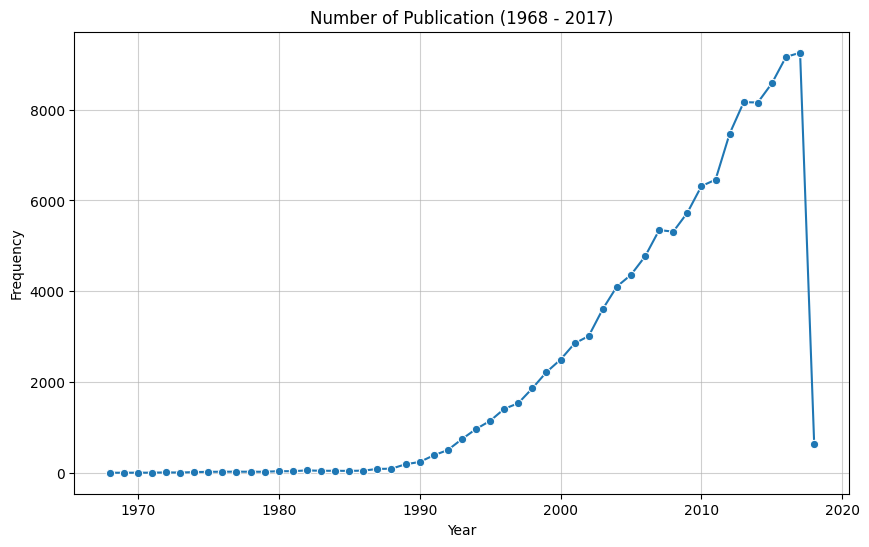

In [ ]:

#graph
x1 = df_pub_year.publicationYear.value_counts().sort_index().index
y1 = df_pub_year.publicationYear.value_counts().sort_index().values
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(data = df_pub_year['publicationYear'], x=x1, y=y1, marker = 'o')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_title("Number of Publication (1968 - 2017)")
plt.grid(True, alpha = 0.6)

plt.show()


The publication of the Reserach on the Strutural Sequence of Protein have continually incresed over the last 3 decades

#### PH Scale Distribution



In [ ]:
# I will split the ph value into three according to the scientific categorization of the Ph such as Acidic if pH <7
#basic if pH >7 and neutral if pH = 7
def ph_scale (ph):
    if ph < 7 :
        ph = 'Acidic'
    elif ph > 7:
        ph = 'Basic'
    else:
        ph = 'Neutral'
    return ph

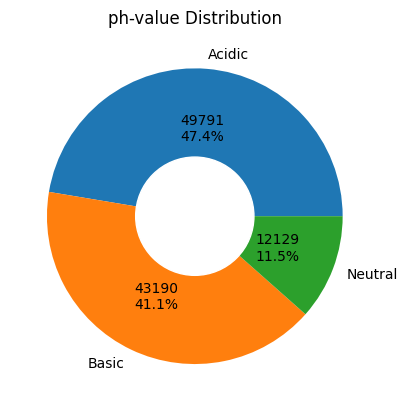

In [ ]:
#Transform the dataset
df_ph = df1.dropna(subset=['phValue']) # dropping missing values in the phValue column only
df_ph['phScale'] = df_ph['phValue'].apply(ph_scale)
#Graph
labels= df_ph['phScale'].value_counts().index
values = df_ph['phScale'].value_counts().values

total = df_ph['phScale'].value_counts().values.sum()

def fmt(x):
    return '{:.0f}\n{:.1f}%'.format(total*x/100, x)

plt.pie(df_ph['phScale'].value_counts().values, labels=df_ph['phScale'].value_counts().index, autopct=fmt)
plt.title('ph-value Distribution')
# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.4, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

#### Crystallization Methods

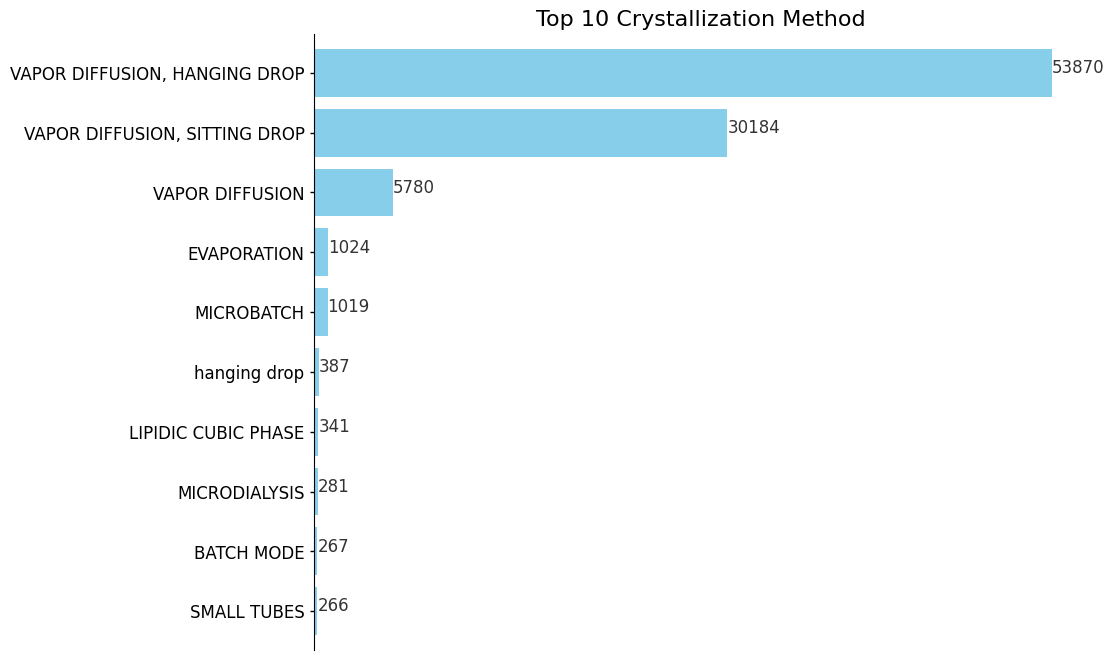

In [ ]:
# The result of this cell Show the Top 10 most used crystallization method
df_cry_meth = df1.dropna(subset=['crystallizationMethod']) # this will drop all missing values in
#the crystallizationMethod column

cry_me = pd.DataFrame(df_cry_meth.crystallizationMethod.value_counts(ascending=False).head(10)).reset_index()
cry_me.columns = ['Crystallization Method','Values']

f,ax = plt.subplots(figsize=(10,8))
cry_me.plot(kind = 'barh',ax=ax,color='skyblue',legend=None,width= 0.8) # 'lightblue'
# get_width pulls left or right; get_y pushes up or down
for i in ax.patches:
    ax.text(i.get_width()+.1, i.get_y()+.40, \
            str(round((i.get_width()), 2)), fontsize=12, color='black',alpha=0.8)
#Set ylabel
ax.set_yticklabels(cry_me['Crystallization Method'])
# invert for largest on top
ax.invert_yaxis()
kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax.tick_params(**kwargs)
x_axis = ax.axes.get_xaxis().set_visible(False)
ax.set_title ('Top 10 Crystallization Method',color='black',fontsize=16)
sns.despine(bottom=True)

#### Most Used Experimental Technique

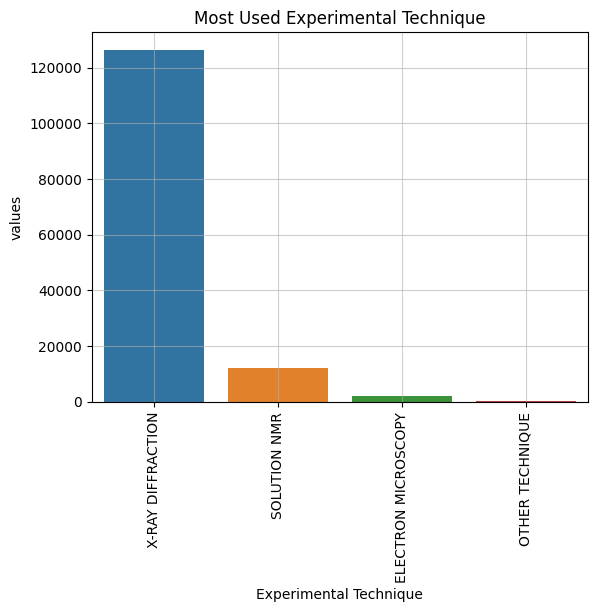

In [ ]:
popular_exp_tech = df1.experimentalTechnique.value_counts()[:3] # Extract the 3 top used Exp Tech
popular_exp_tech_df = pd.DataFrame(popular_exp_tech).reset_index()
popular_exp_tech_df.columns=['Experimental Technique','values']
# ADDING A ROW FOR THE OTHER EXPERIMENTAL TECHNIQUE USED. PLEASE PUT IN MIND THAT TO OTHER TECHNIQUES
#IS JUST A GROUP OF THE REST OF THECNIQUES USED
popular_exp_tech_df.loc[3]  = ['OTHER TECHNIQUE', 449]

labels = popular_exp_tech_df['Experimental Technique']
values = popular_exp_tech_df['values']

plt.title("Most Used Experimental Technique")
plt.xlabel("Experimental Techniques")
plt.ylabel("Frequency")
sns.barplot(x=labels, y=values, data=popular_exp_tech_df)
plt.xticks(rotation=90)
plt.grid(alpha = 0.6)
plt.show()

The X-RAY DIFFRACTION is by far the most used Experimental Technique during the Study of the Protein Sequences

#### Macromolecule Types

In [ ]:
molecule_type_df = df1.dropna(subset=['macromoleculeType'])
mol_type = pd.DataFrame(molecule_type_df.macromoleculeType.value_counts(ascending=False).head(10)).reset_index()
mol_type.columns = ['Macromolecule Type','Values']
mol_type

,Macromolecule Type,Values
0,Protein,127798
1,Protein#DNA,4176
2,Protein#RNA,2162
3,DNA,1744
4,RNA,1295
5,Protein#DNA#RNA,250
6,DNA/RNA Hybrid,58
7,DNA#RNA,51
8,Protein#DNA#DNA/RNA Hybrid,34
9,RNA#DNA/RNA Hybrid,27


In [ ]:
df_mol = pd.DataFrame(round(((molecule_type_df.macromoleculeType.value_counts(ascending=False)/molecule_type_df.shape[0])*100),2).head(10)).reset_index()
df_mol.columns = ['Macromolecule Type','Percent Values']
df_mol

,Macromolecule Type,Percent Values
0,Protein,92.85
1,Protein#DNA,3.03
2,Protein#RNA,1.57
3,DNA,1.27
4,RNA,0.94
5,Protein#DNA#RNA,0.18
6,DNA/RNA Hybrid,0.04
7,DNA#RNA,0.04
8,Protein#DNA#DNA/RNA Hybrid,0.02
9,RNA#DNA/RNA Hybrid,0.02


In [ ]:
total = molecule_type_df.macromoleculeType.value_counts().values.sum()
total

137636

In [ ]:
top5 = mol_type.head(5)
top5

,Macromolecule Type,Values
0,Protein,127798
1,Protein#DNA,4176
2,Protein#RNA,2162
3,DNA,1744
4,RNA,1295


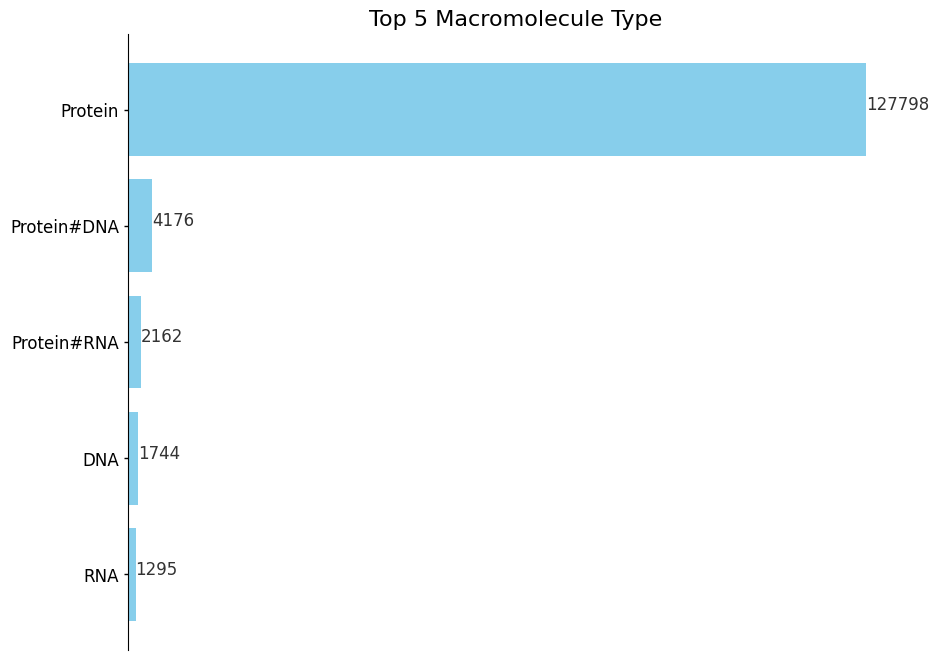

In [ ]:
f,ax = plt.subplots(figsize=(10,8))
top5.plot(kind = 'barh',ax=ax,color='skyblue',legend=None,width= 0.8)
# get_width pulls left or right; get_y pushes up or down
for i in ax.patches:
    ax.text(i.get_width()+.1, i.get_y()+.40, \
            str(round((i.get_width()), 2)), fontsize=12, color='black',alpha=0.8)
#Set ylabel
ax.set_yticklabels(top5['Macromolecule Type'])
# invert for largest on top
ax.invert_yaxis()
kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax.tick_params(**kwargs)
x_axis = ax.axes.get_xaxis().set_visible(False)
ax.set_title ('Top 5 Macromolecule Type',color='black',fontsize=16)
sns.despine(bottom=True)

proteins are representing 92.85% of macromolecule type in dataset.

#### Classification Distribution

There are 5050 Unique Classification Types and the top 10 Classification type accounts for more than 50% of the classification in the dataset


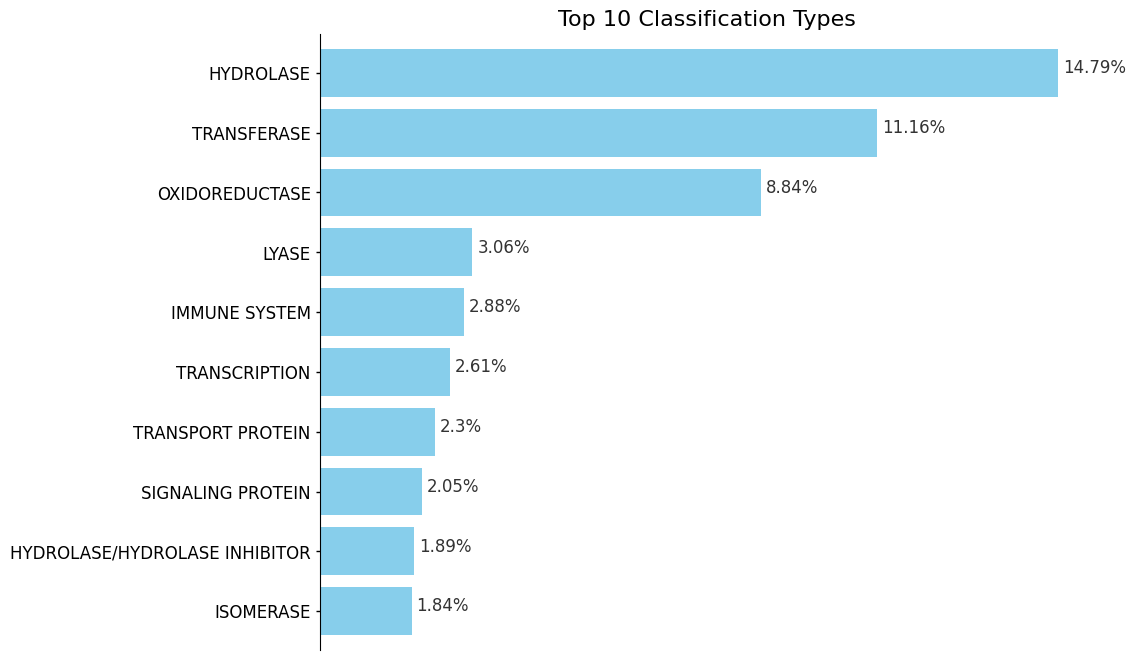

In [ ]:
#classification distribution
clasific =df1.classification.value_counts(ascending=False)
df_class = pd.DataFrame(round(((clasific/df1.shape[0])*100),2).head(10)).reset_index()
df_class.columns = ['Classification', 'percent_value']
print('There are {} Unique Classification Types and the top 10 Classification type accounts for more than 50% of the classification in the dataset'.format(df1.classification.nunique()))
f,ax = plt.subplots(figsize=(10,8))

df_class.plot(kind = 'barh',ax=ax,color='skyblue',legend=None,width= 0.8) # 'slategray'
# get_width pulls left or right; get_y pushes up or down
for i in ax.patches:
    ax.text(i.get_width()+.1, i.get_y()+.40, \
            str(round((i.get_width()), 2))+'%', fontsize=12, color='black',alpha=0.8)
#Set ylabel
ax.set_yticklabels(df_class['Classification'])
# invert for largest on top
ax.invert_yaxis()
kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':'large'}
ax.tick_params(**kwargs)
x_axis = ax.axes.get_xaxis().set_visible(False)
ax.set_title ('Top 10 Classification Types',color='black',fontsize=16)
sns.despine(bottom=True)

In [ ]:
from scipy import stats
from scipy.stats import norm, skew, kurtosis
def kde_plot(df,input1,input2,input3):
    f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    sns.kdeplot(df[input1],ax = ax1,color ='blue',shade=True,
                label=("Skewness : %.2f"%(df[input1].skew()),
                       "Kurtosis: %.2f"%(df[input1].kurtosis())))
    sns.kdeplot(df[input2], ax = ax2,color='r',shade=True,
                label=("Skewness : %.2f"%(df[input2].skew()),
                       "Kurtosis: %.2f"%(df[input2].kurtosis())))
    sns.kdeplot(df[input3], ax = ax3,color='gray',shade=True,
                label=("Skewness : %.2f"%(df[input3].skew()),
                       "Kurtosis: %.2f"%(df[input3].kurtosis())))
    axes = [ax1,ax2,ax3]
    input = [input1,input2,input3]
    for j in range(len(axes)):
        axes[j].set_xlabel(input[j],color='black')
        axes[j].set_title(input[j] + ' Kdeplot',fontsize=14)
        axes[j].axvline(df[input[j]].mean() , color ='g',linestyle = '--')
        axes[j].legend(fontsize=8) # bbox_to_anchor=(0, 1.02, 1, 0.2), loc ='lower left', ncol = 2
    sns.despine()
    return plt.show()


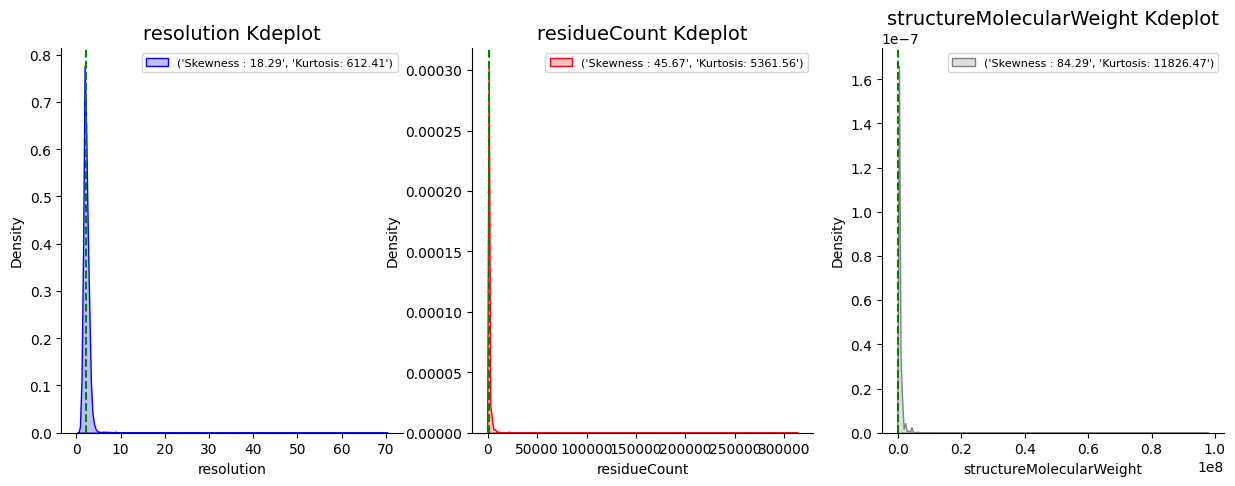

In [ ]:
type_df = df1[['resolution','residueCount','structureMolecularWeight']]
kde_plot(type_df, 'resolution','residueCount','structureMolecularWeight')

We can observed that the `resolution`, `residueCount` and `structureMolecularWeight` distributions are very skewed.

A better approach to this problem is to transform the feature above using the log function to reduce the skew.

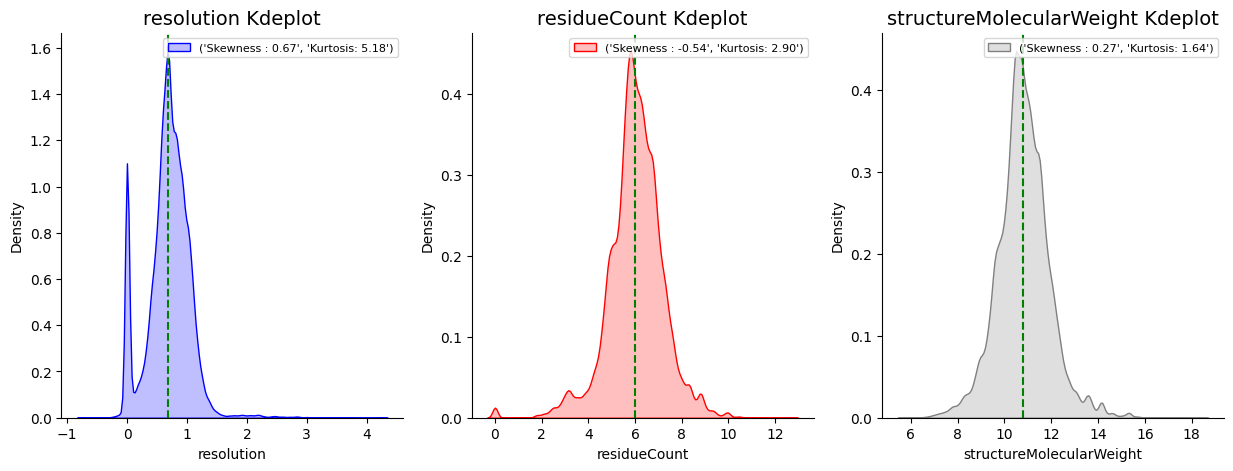

In [ ]:
for i in ['resolution','residueCount','structureMolecularWeight']:
    type_df[i] = type_df[i].map(lambda i: np.log(i) if i > 0 else 0)
kde_plot(type_df, 'resolution','residueCount','structureMolecularWeight')

The Kdeplots above do not give a clear interpretation of the data from the respective columns. I will use some statistical method to extract some useful meaning from the columns. I will play with some statistical analysis to check the normal distribution of these columns.

* plot the Normal Q-Q plot to verify if these distribution are normaly distributed
* Interpret the plot

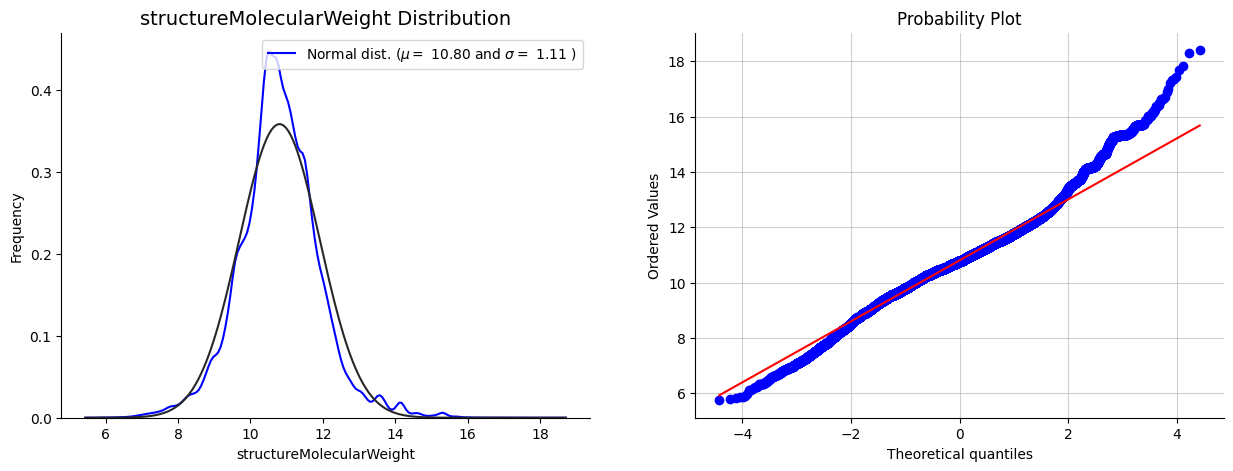

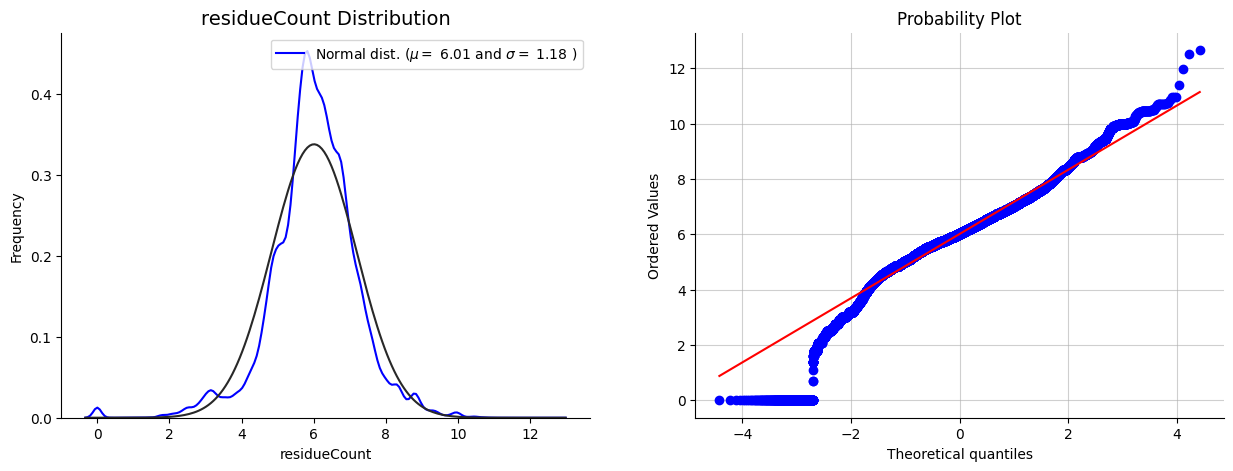

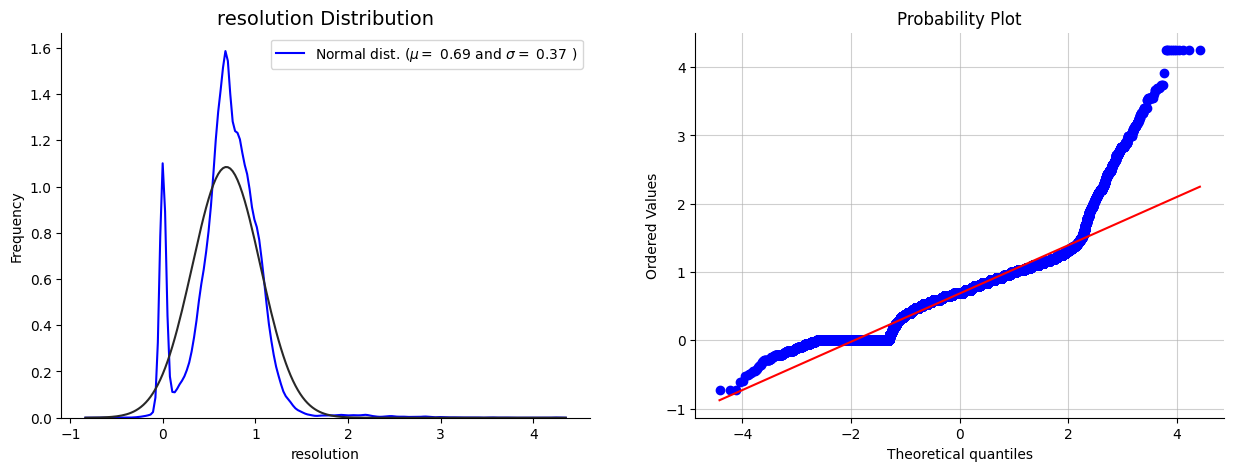

In [ ]:
# Drop all null values from this columns
def norm_plot (df, input):
    (mu, sigma) = norm.fit(df[input])
    f, (ax1, ax2)= plt.subplots(1,2,figsize=(15,5))
    # Apply the log transformation on the column
    sns.distplot(df[input],ax = ax1,fit=norm,color ='blue',hist=False)
    plt.grid(alpha = 0.6)
    ax1.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
    ax1.set_ylabel('Frequency')
    ax1.set_title(input +' Distribution',color='black',fontsize=14)
    #Get also the QQ-plot
    res = stats.probplot(df[input], plot=ax2)
    sns.despine()
    plt.grid(alpha = 0.6)
    return plt.show()
norm_plot(type_df, 'structureMolecularWeight')
norm_plot(type_df, 'residueCount')
norm_plot(type_df, 'resolution')

As we can see, there’s still a bit of noise at the upper tail, but the most part of the distributions matches quite well for `structureMolecularWeight`. For `residueCount` more noisy at the lower tail than upper tail but center part of the distributions matches well. `resolution` is highly noisy at the upper part and it's also noisy at lower tail, only center matches the normal distribution.

In [ ]:
data_corr = df1.corr()
data_corr

,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,phValue,publicationYear
residueCount,1.000000,0.287050,0.550563,-0.007185,0.148613,0.181235,0.011921,0.084021
resolution,0.287050,1.000000,0.153623,-0.006738,0.428840,0.469231,0.024635,0.032306
structureMolecularWeight,0.550563,0.153623,1.000000,-0.015306,0.075296,0.088947,0.007558,0.043666
crystallizationTempK,-0.007185,-0.006738,-0.015306,1.000000,-0.053185,-0.067303,-0.002629,0.032561
densityMatthews,0.148613,0.428840,0.075296,-0.053185,1.000000,0.809973,0.013257,0.012797
densityPercentSol,0.181235,0.469231,0.088947,-0.067303,0.809973,1.000000,0.016484,0.026886
phValue,0.011921,0.024635,0.007558,-0.002629,0.013257,0.016484,1.000000,0.029359
publicationYear,0.084021,0.032306,0.043666,0.032561,0.012797,0.026886,0.029359,1.000000


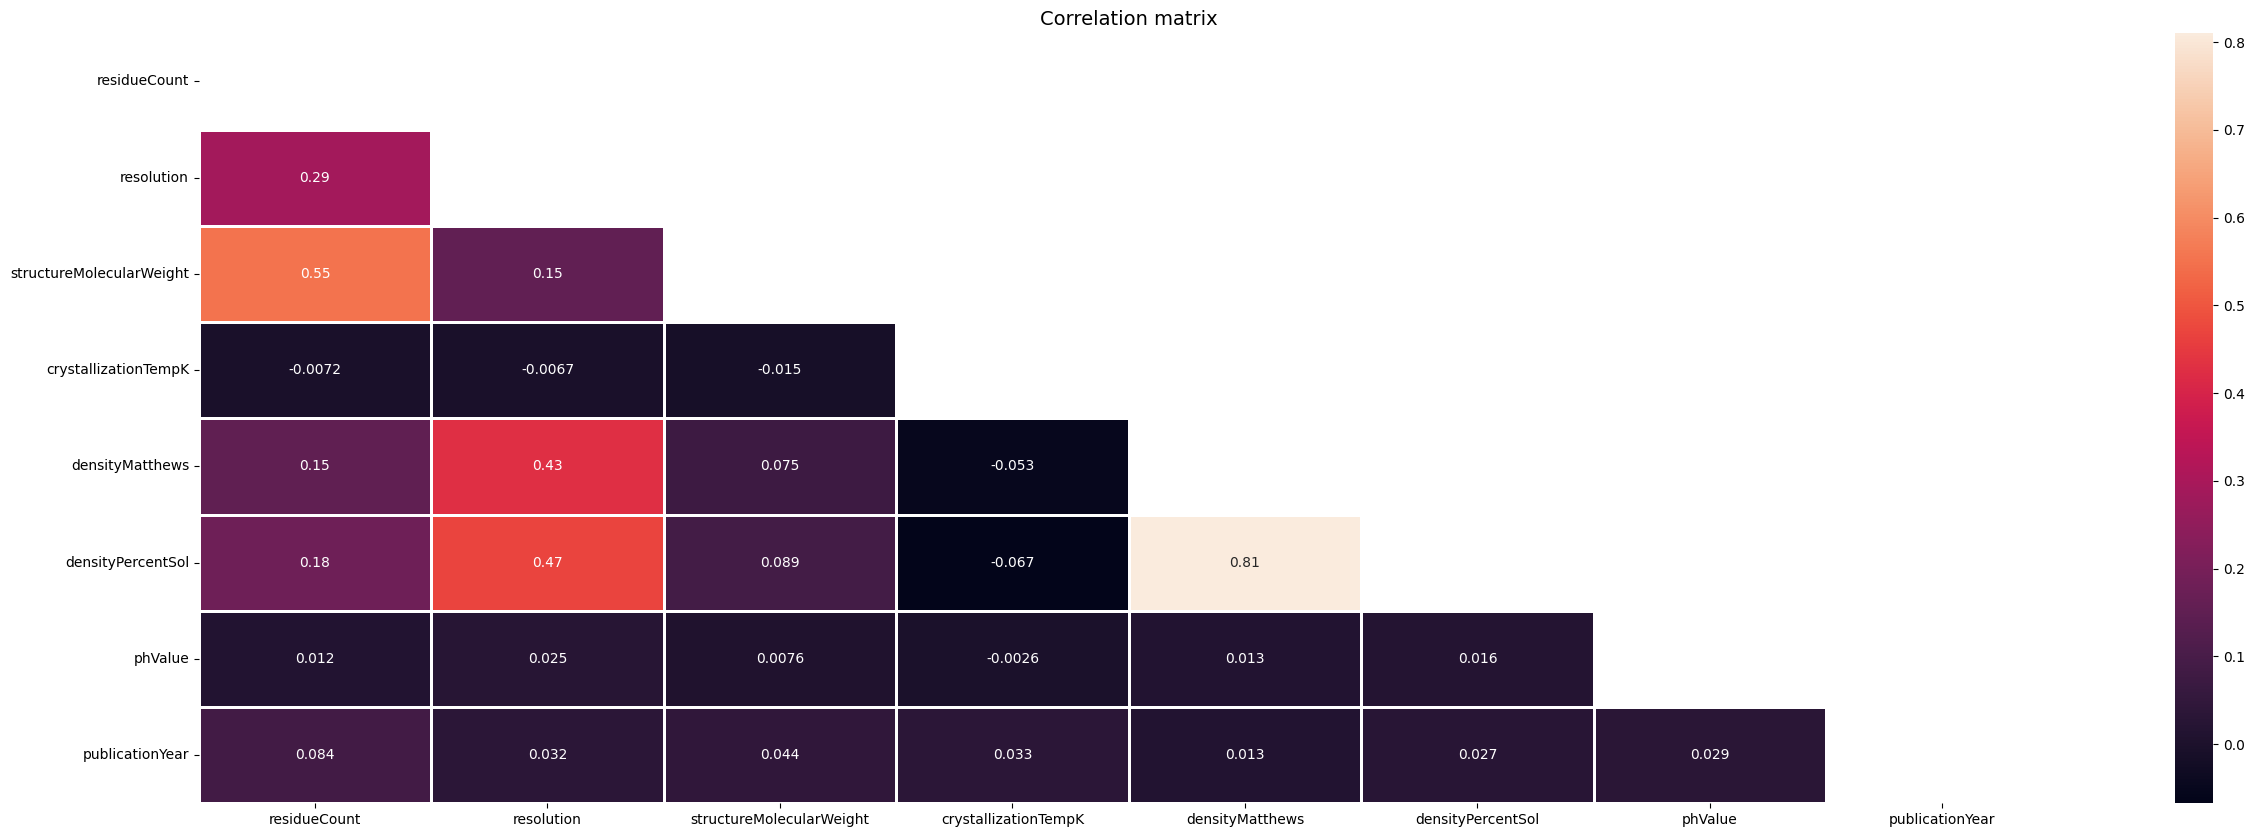

In [ ]:
plt.figure(figsize=(30, 10))
matrix = np.triu(data_corr)
sns.heatmap(data_corr, annot=True, linewidth=.8, mask=matrix, cmap="rocket")
plt.title('Correlation matrix', fontsize = 14)
plt.show()

`densityMatthews` and `densityPercentSol` are highly correlated and value of correlation coefficient is 0.81. `structureMolecularWeight` has strong correlation with `residueCount` value is 0.55. `resolution` has correlation coefficient value 0.47 and 0.43 with `densityPercentSol` and `densityMatthews`.

## Loading protein sequence data

In [ ]:
# df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb_data_seq.csv')
df2 = pd.read_csv('pdb_data_seq.csv')
df2.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467304 entries, 0 to 467303
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        467304 non-null  object
 1   chainId            467294 non-null  object
 2   sequence           467276 non-null  object
 3   residueCount       467304 non-null  int64 
 4   macromoleculeType  432487 non-null  object
dtypes: int64(1), object(4)
memory usage: 17.8+ MB


In [ ]:
protein_df = pd.merge(df1[['structureId','classification','macromoleculeType']], df2[['sequence','structureId']], on='structureId', how='inner')
protein_df.head()

,structureId,classification,macromoleculeType,sequence
0,100D,DNA-RNA HYBRID,DNA/RNA Hybrid,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,DNA/RNA Hybrid,CCGGCGCCGG
2,101D,DNA,DNA,CGCGAATTCGCG
3,101D,DNA,DNA,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [ ]:
protein_df = protein_df[protein_df['macromoleculeType'] == 'Protein']
protein_df.reset_index(inplace=True, drop=True)
protein_df.head()

,structureId,classification,macromoleculeType,sequence
0,101M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,HYDROLASE(O-GLYCOSYL),Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3,103L,HYDROLASE(O-GLYCOSYL),Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
4,103M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [ ]:
protein_df.shape

(346325, 4)

In [ ]:
protein_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346325 entries, 0 to 346324
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        346325 non-null  object
 1   classification     346324 non-null  object
 2   macromoleculeType  346325 non-null  object
 3   sequence           346322 non-null  object
dtypes: object(4)
memory usage: 10.6+ MB


#### drop the null values

In [ ]:
protein_df.dropna(axis=0, inplace=True)
protein_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346321 entries, 0 to 346324
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        346321 non-null  object
 1   classification     346321 non-null  object
 2   macromoleculeType  346321 non-null  object
 3   sequence           346321 non-null  object
dtypes: object(4)
memory usage: 13.2+ MB


#### Remove Duplicates

In [ ]:
protein_df.duplicated().any()

True

In [ ]:
protein_df.duplicated().sum()

179644

In [ ]:
protein_df = protein_df.drop_duplicates()

In [ ]:
protein_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166677 entries, 0 to 346321
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        166677 non-null  object
 1   classification     166677 non-null  object
 2   macromoleculeType  166677 non-null  object
 3   sequence           166677 non-null  object
dtypes: object(4)
memory usage: 6.4+ MB


#### Preprocessing of text in the classification column.

In [ ]:
protein_df['classification'] = protein_df['classification'].astype('str')
protein_df['classification'] = protein_df['classification'].str.lower()
protein_df['classification'] = protein_df['classification'].str.replace('(', '/')
protein_df['classification'] = protein_df['classification'].str.replace(',', '/')
protein_df['classification'] = protein_df['classification'].str.replace(', ', '/')
protein_df['classification'] = protein_df['classification'].str.replace('/ ', '/')
protein_df['classification'] = protein_df['classification'].str.replace(')', '')

# Maintaing class ordering. There are the same classes with different order
#ex. viral protein/immune system and immune system/viral protein
protein_df['classification'] = protein_df['classification'].apply(lambda x:"/".join(sorted(x.split('/'))))

protein_df.head(5)

,structureId,classification,macromoleculeType,sequence
0,101M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,hydrolase/o-glycosyl,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3,103L,hydrolase/o-glycosyl,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
4,103M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [ ]:
protein_df.describe()

,structureId,classification,macromoleculeType,sequence
count,166677,166677,166677,166677
unique,127383,3017,1,89083
top,5J7Y,hydrolase,Protein,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...
freq,74,24196,166677,657


In [ ]:
protein_df['sequence'][0]

'MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG'

### Sequence Counts

In [ ]:
protein_df['seq_char_count']= protein_df['sequence'].apply(lambda x: len(x))
protein_df.head()

,structureId,classification,macromoleculeType,sequence,seq_char_count
0,101M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154
1,102L,hydrolase/o-glycosyl,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165
2,102M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154
3,103L,hydrolase/o-glycosyl,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167
4,103M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154


**NOTE:** I just considered the sequences more than 30AA long.

In [ ]:
protein_df = protein_df[protein_df['seq_char_count'] >30]
protein_df

,structureId,classification,macromoleculeType,sequence,seq_char_count
0,101M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154
1,102L,hydrolase/o-glycosyl,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165
2,102M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154
3,103L,hydrolase/o-glycosyl,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167
4,103M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154
...,...,...,...,...,...
346314,9RSA,hydrolase /phosphoric diester,Protein,KETAAAKFERQHMDSSTSAASSSNYCNQMMKSRNLTKDRCKPVNTF...,124
346316,9RUB,carbon-carbon/lyase,Protein,MDQSSRYVNLALKEEDLIAGGEHVLCAYIMKPKAGYGYVATAAHFA...,466
346318,9WGA,agglutinin/lectin,Protein,ERCGEQGSNMECPNNLCCSQYGYCGMGGDYCGKGCQNGACWTSKRC...,171
346320,9XIA,intramolecular oxidoreductase/isomerase,Protein,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...,388


In [ ]:
# protein_df.to_csv('/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/pdb_protein_seq_2.csv', index = False)

In [ ]:
# protein_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/pdb_protein_seq_2.csv')
# protein_df.head()

In [ ]:
uniq_classes = np.unique(protein_df['classification'].values)
len(uniq_classes)

2950

In [ ]:
protein_df.describe()

,seq_char_count
count,156068.000000
mean,278.822648
std,201.573606
min,31.000000
25%,148.000000
50%,241.000000
75%,351.000000
max,5037.000000


In [ ]:
# 90% sequences have maximum length below this number
print(protein_df.seq_char_count.quantile(0.9))

494.0


90% sequences have maximum length below 494.

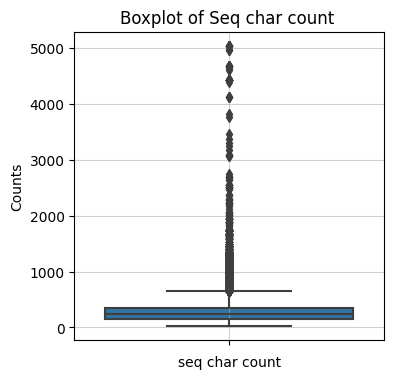

Mean: 278.8226478201809
Median: 241.0
Standard Deviation:201.57296050252552
Interquartile Range: 203.0
Lower Quartile: 148.0
Upper Quartile: 351.0
Outliers Upper limit: 655.5
Outliers lower limit: -156.5


In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.boxplot(y=protein_df["seq_char_count"])
ax.set_xlabel('seq char count')
ax.set_ylabel('Counts')
ax.set_title("Boxplot of Seq char count ")
plt.grid(True, alpha = 0.6)

plt.show()

# showing mean, median, upper quartile, lower quartile and inter quartile range
mean = np.mean(protein_df['seq_char_count'])
median = np.median(protein_df['seq_char_count'])
std_dev = np.std(protein_df['seq_char_count'])
upper_quartile = np.percentile(protein_df['seq_char_count'], 75)
lower_quartile = np.percentile(protein_df['seq_char_count'], 25)

iqr = upper_quartile - lower_quartile
print(f"Mean: {mean}\nMedian: {median}\nStandard Deviation:{std_dev}\nInterquartile Range: {iqr}\nLower Quartile: {lower_quartile}\nUpper Quartile: {upper_quartile}\nOutliers Upper limit: {upper_quartile+1.5*iqr}\nOutliers lower limit: {lower_quartile-1.5*iqr}")

After observing the above boxplot, I can conclude that mean seq char count is ~ 279 with standard deviation of ~202. The lower limit of box represent lower quartile which is 148.0, and the upper limit represent upper quartile which is 351.0. Any value above the whisker's upper limit and below the whisker's lower limit considered as outlier. As we can observed that outliers are above the 656 counts.

In [ ]:
def plot_seq_count(df):
  sns.histplot(df.loc[df.seq_char_count<656].values, kde = True, legend = False)
  plt.title(f'Sequence char count for Protein dataset')
  plt.xlabel('Sequence char count')
  plt.ylabel('Counts')
  plt.grid(True)
  plt.show()

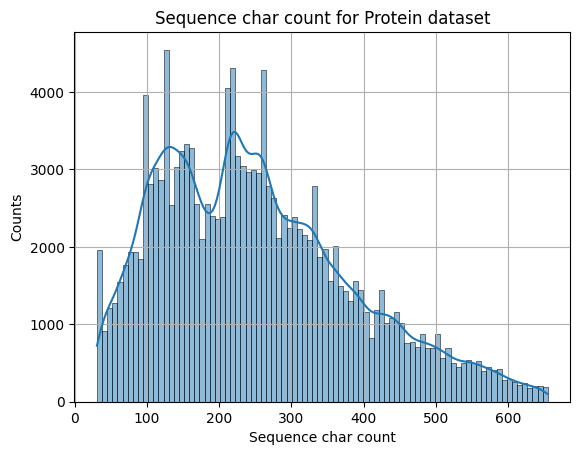

In [ ]:
plot_seq_count(protein_df)

**Observation:**

* Sequence lengh in the given dataset is highly skewed.
* Most of the unaligned amino acid sequences have character counts in the range of 50-450.

### Sequence Code Frequency
Amino acid sequences are represented with their corresponding 1 letter code, for example, code for alanine is (A), arginine is (R) and so on. The complete list of amino acids with there code can be found [here](http://www.cryst.bbk.ac.uk/education/AminoAcid/the_twenty.html).

In [ ]:
def get_code_freq(df):
  df = df.apply(lambda x: " ".join(x))

  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space

  print(f'Codes:')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

In [ ]:
code_freq = get_code_freq(protein_df['sequence'])
code_freq

Codes:
Total unique codes: 25


,Code,Freq
0,L,3926915
1,A,3367132
2,G,3201291
3,V,2982891
4,S,2827563
5,E,2826774
6,K,2507570
7,D,2478207
8,T,2453308
9,I,2383153


In [ ]:
def plot_code_freq(df, data_name):
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)
  plt.grid(alpha = 0.6)
  plt.show()

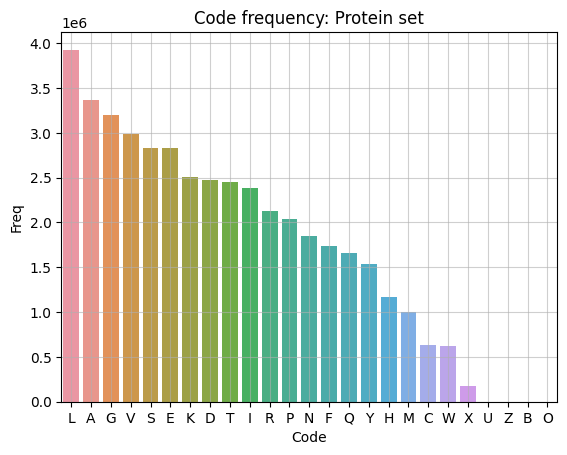

In [ ]:
plot_code_freq(code_freq, 'Protein set')

**Observations**

* Most frequent amino acid code is L followed by A, G, V.
* As we can see, that the uncommon amino acids (i.e., X, U, B, O, Z) are present in very less quantity. Therefore we can consider only 20 common natural amino acids for sequence encoding.

### Protein families with most sequences(No. of observations)

In [ ]:
# I will consider classes with more than 100 observations.
protein_df.groupby('classification').size().sort_values(ascending=False).head(95)

classification
hydrolase                        23505
transferase                      16566
oxidoreductase                   14607
immune system                     7889
hydrolase/hydrolase inhibitor     6790
                                 ...  
phosphotransferase                 108
ribosome                           106
flavoprotein                       104
cell invasion                      103
antibiotic/transferase             101
Length: 95, dtype: int64

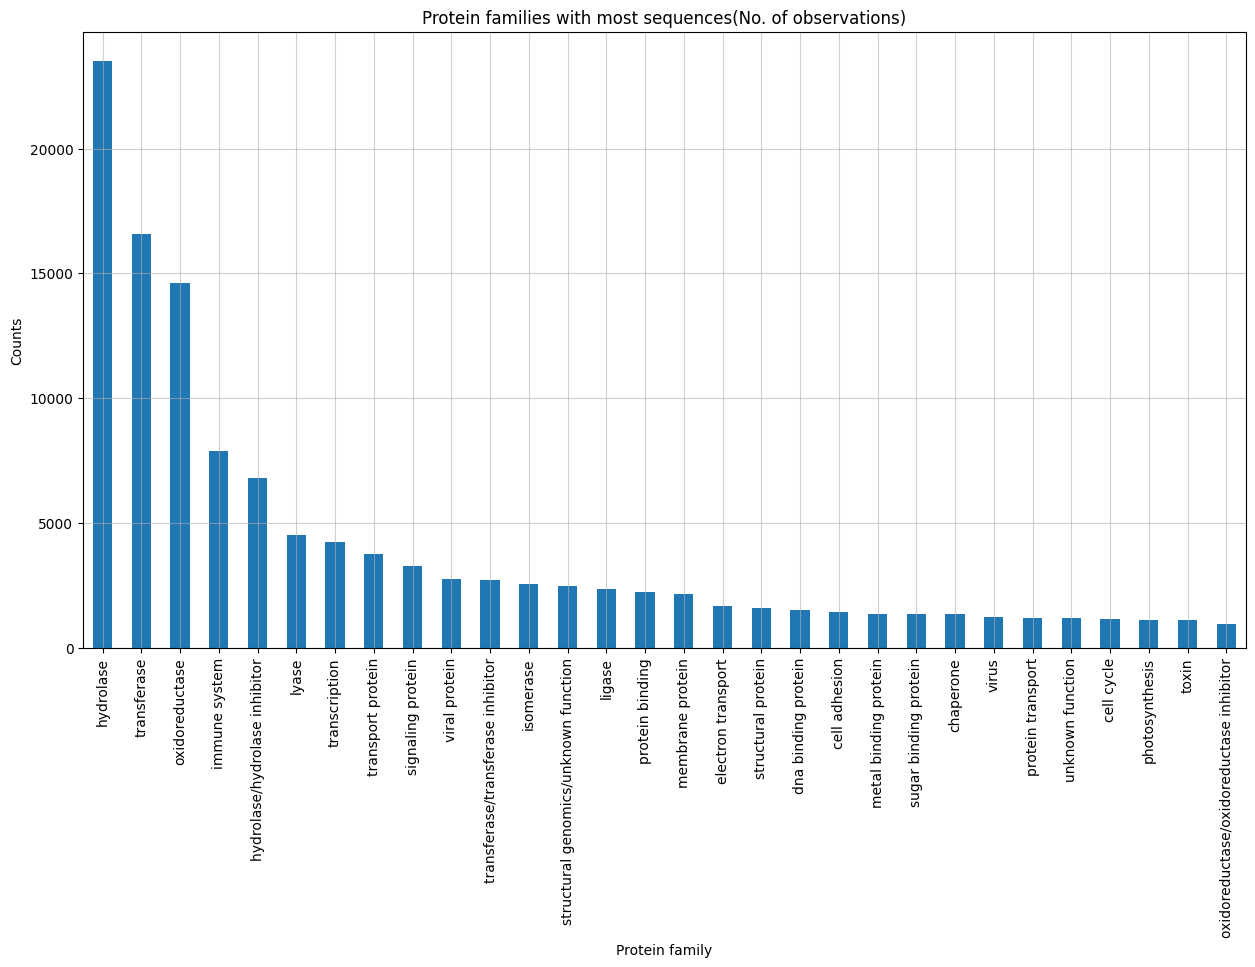

In [ ]:
plt.figure(figsize=(15,8))
protein_df.groupby('classification').size().sort_values(ascending=False).head(30).plot(kind = 'bar')
plt.title('Protein families with most sequences(No. of observations)')
plt.xlabel('Protein family')
plt.ylabel('Counts')
plt.grid(alpha = 0.6)

# plt.savefig('/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb_classes1.jpg', dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
# Considering top 95 classes based on most observations because of limited computational power.
classes = protein_df['classification'].value_counts()[:95].index.tolist()

In [ ]:
# Filter dataset's records for classification types >=95
data = protein_df[protein_df.classification.isin(classes)]
print('%d is the number of records in the final filtered dataset' %data.shape[0])

138261 is the number of records in the final filtered dataset


In [ ]:
def clean_seq(df):
    """
    A method to preproces seqs

    """
    seqs = []
    for sequence in df["sequence"]:
        sequence =re.sub(r"[XUZOB]", "", str(sequence))
        seqs.append(sequence)
    df['clean_sequence'] = seqs
    return df

In [ ]:
data = clean_seq(data)
data

,structureId,classification,macromoleculeType,sequence,seq_char_count,clean_sequence
0,101M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,hydrolase/o-glycosyl,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3,103L,hydrolase/o-glycosyl,Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
4,103M,oxygen transport,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
...,...,...,...,...,...,...
346304,9LYZ,hydrolase /o-glycosyl,Protein,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...,129,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...
346306,9NSE,oxidoreductase,Protein,SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...,444,SRAPAPATPHAPDHSPAPNSPTLTRPPEGPKFPRVKNWELGSITYD...
346308,9PAI,hydrolase inhibitor,Protein,VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...,346,VHHPPSYVAHLASDFGVRVFQQVAQASKDRNVVFSPYGVASVLAML...
346309,9PAI,hydrolase inhibitor,Protein,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP,33,MAPEEIIMDRPFLFVVRHNPTGTVLFMGQVMEP


In [ ]:
labellist=sorted(list(set(data['classification'].unique())))

labels_dict={label:i for i,label in enumerate(labellist)}
labels_dict

{'allergen': 0,
 'antibiotic/hydrolase': 1,
 'antibiotic/transferase': 2,
 'antimicrobial protein': 3,
 'apoptosis': 4,
 'biosynthetic protein': 5,
 'biotin-binding protein': 6,
 'blood clotting': 7,
 'calcium-binding protein': 8,
 'cell adhesion': 9,
 'cell cycle': 10,
 'cell invasion': 11,
 'chaperone': 12,
 'contractile protein': 13,
 'cytokine': 14,
 'de novo protein': 15,
 'dna binding protein': 16,
 'electron transport': 17,
 'electron transport/oxidoreductase': 18,
 'electron transport/photosynthesis': 19,
 'endocytosis': 20,
 'endocytosis/exocytosis': 21,
 'flavoprotein': 22,
 'fluorescent protein': 23,
 'gene regulation': 24,
 'growth factor/hormone': 25,
 'hormone': 26,
 'hormone receptor': 27,
 'hydrolase': 28,
 'hydrolase /o-glycosyl': 29,
 'hydrolase inhibitor': 30,
 'hydrolase/hydrolase inhibitor': 31,
 'hydrolase/immune system': 32,
 'hydrolase/inhibitor': 33,
 'hydrolase/o-glycosyl': 34,
 'hydrolase/protein binding': 35,
 'hydrolase/signaling protein': 36,
 'hydrolase/t

**NOTE:** As we can see there are still some more preprocessing required. like 'hydrolase /o-glycosyl' and 'hydrolase/o-glycosyl' is same and some other classes like 'hydrolase/immune system', 'hydrolase/o-glycosyl' and some more are subcategories of 'hydrolase'.

In [ ]:
data['classification'] = data['classification'].str.replace('hydrolase /o-glycosyl', 'hydrolase/o-glycosyl') # inplace = True
data['classification'] = data['classification'].str.replace('hydrolase/inhibitor', 'hydrolase inhibitor')
data['classification'] = data['classification'].str.replace('hydrolase/hydrolase inhibitor', 'hydrolase inhibitor')
data['classification'] = data['classification'].str.replace('isomerase/isomerase inhibitor', 'isomerase inhibitor')
data['classification'] = data['classification'].str.replace('ligase/ligase inhibitor', 'ligase inhibitor')
data['classification'] = data['classification'].str.replace('lyase/lyase inhibitor', 'lyase inhibitor')
data['classification'] = data['classification'].str.replace('membrane protein/transport protein', 'membrane protein')
data['classification'] = data['classification'].str.replace('oxidoreductase/oxidoreductase inhibitor', 'oxidoreductase inhibitor')
data['classification'] = data['classification'].str.replace('transcription regulation', 'transcription regulator')
data['classification'] = data['classification'].str.replace('transcription/transcription inhibitor', 'transcription inhibitor')
data['classification'] = data['classification'].str.replace('transferase/transferase inhibitor', 'transferase inhibitor')
data['classification'] = data['classification'].str.replace('structural genomics/unknown function', 'unknown function')

In [ ]:
data['classification'] = data['classification'].str.replace('antibiotic/hydrolase', 'antibiotic hydrolase') # inplace = True
data['classification'] = data['classification'].str.replace('antibiotic/transferase', 'antibiotic transferase')
data['classification'] = data['classification'].str.replace('electron transport/oxidoreductase', 'electron transport')
data['classification'] = data['classification'].str.replace('electron transport/photosynthesis', 'electron transport')
data['classification'] = data['classification'].str.replace('growth factor/hormone', 'growth factor hormone')
data['classification'] = data['classification'].str.replace('hydrolase/immune system', 'hydrolase')
data['classification'] = data['classification'].str.replace('hydrolase/o-glycosyl', 'hydrolase')
data['classification'] = data['classification'].str.replace('hydrolase/protein binding', 'hydrolase')
data['classification'] = data['classification'].str.replace('hydrolase/signaling protein', 'hydrolase')
data['classification'] = data['classification'].str.replace('hydrolase/transferase', 'hydrolase')
data['classification'] = data['classification'].str.replace('hydrolase/transport protein', 'hydrolase')
data['classification'] = data['classification'].str.replace('immune system/viral protein', 'immune system')
data['classification'] = data['classification'].str.replace('immune system/virus', 'immune system')
data['classification'] = data['classification'].str.replace('inhibitor/transferase', 'transferase inhibitor')
data['classification'] = data['classification'].str.replace('oxygen storage/transport', 'oxygen storage')
data['classification'] = data['classification'].str.replace('signaling protein/transferase', 'signaling protein')
data['classification'] = data['classification'].str.replace('transcription/transferase', 'transcription')

In [ ]:
#make a list of all of the unique labels in the dataframe
#sorting it means that it will also be in the same order (alphabetical) rather than depending on order in the training / testing data
labellist=sorted(list(set(data['classification'].unique())))

labels_dict={label:i for i,label in enumerate(labellist)}
labels_dict

{'allergen': 0,
 'antibiotic hydrolase': 1,
 'antibiotic transferase': 2,
 'antimicrobial protein': 3,
 'apoptosis': 4,
 'biosynthetic protein': 5,
 'biotin-binding protein': 6,
 'blood clotting': 7,
 'calcium-binding protein': 8,
 'cell adhesion': 9,
 'cell cycle': 10,
 'cell invasion': 11,
 'chaperone': 12,
 'contractile protein': 13,
 'cytokine': 14,
 'de novo protein': 15,
 'dna binding protein': 16,
 'electron transport': 17,
 'endocytosis': 18,
 'endocytosis/exocytosis': 19,
 'flavoprotein': 20,
 'fluorescent protein': 21,
 'gene regulation': 22,
 'growth factor hormone': 23,
 'hormone': 24,
 'hormone receptor': 25,
 'hydrolase': 26,
 'hydrolase inhibitor': 27,
 'immune system': 28,
 'immunoglobulin': 29,
 'isomerase': 30,
 'isomerase inhibitor': 31,
 'lectin': 32,
 'ligase': 33,
 'ligase inhibitor': 34,
 'lipid binding protein': 35,
 'lipid transport': 36,
 'luminescent protein': 37,
 'lyase': 38,
 'lyase inhibitor': 39,
 'membrane protein': 40,
 'metal binding protein': 41,
 'm

**NOTE:** 75 classes are left in the final dataset after applying pre-processing steps.

In [ ]:
labels_dict_reverse = {value:key for (key,value)in labels_dict.items()}

In [ ]:
data.groupby('classification').size().sort_values(ascending=False).head(75)

classification
hydrolase                 24856
transferase               16566
oxidoreductase            14607
immune system              8939
hydrolase inhibitor        7265
                          ...  
phosphotransferase          108
ribosome                    106
flavoprotein                104
cell invasion               103
antibiotic transferase      101
Length: 75, dtype: int64

#### Saving the cleaned data

In [ ]:
# data.to_csv('/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/pdb_protein_seq_clean.csv', index = False)
# data.to_csv('pdb_protein_seq_clean.csv', index = False)

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/pdb_protein_seq_clean.csv')
# data = pd.read_csv('pdb_protein_seq_clean.csv')
# data.head()